In [1]:
import sys
from datetime import datetime
sys.path.append('../')

# Custom print class
from CustomPrint import CustomPrint
print_ = CustomPrint()

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# ML algo
from RegressionLogistic import LogisticRegressionCustom # I use my implementation ;)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# CV split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss, roc_curve, auc
from scipy import stats

### Load dataset

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

### Let's check memory usage

In [3]:
mem_train = df_train.memory_usage().sum() / 1e6
mem_test = df_test.memory_usage().sum() / 1e6
print('Total memory used : {:.2f} MB'.format(mem_train+mem_test))

Total memory used : 242.44 MB


### Let's check some baseline scores

In [4]:
y_true = df_train['target'].values

y_hat = np.random.uniform(0, 1, len(y_true))
print('logloss with y_true and random predictions\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

y_hat[:] = 0.5
print('logloss with y_true and 0.5 predictions\t\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

y_hat[:] = y_true.mean()
print('logloss with y_true and target mean predictions\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

logloss with y_true and random predictions		0.997
logloss with y_true and 0.5 predictions			0.693
logloss with y_true and target mean predictions		0.550


*** We manage to get 0.55 logloss without any machine learning ***<br />
*** Can we do better ? ***

###  Very simple processing of the data

In [5]:
id_train = df_train['ID'].values
id_test = df_test['ID'].values

# drop v22 and v107
df_train.drop(['ID', 'v22', 'v107'], 1, inplace=True)
df_test.drop(['ID', 'v22', 'v107'], 1, inplace=True)

# let's one-hot encode all the categorical values
# we need to concat df_train and df_test because if one value doesn't appear in the other one, we going to have different columns
df = pd.concat([df_train, df_test]).reset_index(drop=True)

# to make this more simple, we impute all NaNs values with -1
df.fillna(-1, inplace=True)

# you need to save memory, let's go sparse !
df = pd.get_dummies(df, sparse=True)

df_train = df[df['target'] >= 0].copy()
df_test = df[df['target'] == -1].copy()

df_train.drop(['target'], 1, inplace=True)
df_test.drop(['target'], 1, inplace=True)

del df

print('Shape df_train : {}, {}'.format(*df_train.shape))
print('Shape df_test : {}, {}'.format(*df_test.shape))

Shape df_train : 114321, 490
Shape df_test : 114393, 490


### Let's check memory usage (again)

In [6]:
mem_train = df_train.memory_usage().sum() / 1e6
mem_test = df_test.memory_usage().sum() / 1e6
print('Total memory used : {:.2f} MB'.format(mem_train+mem_test))

Total memory used : 210.65 MB


# Let's do some Machine Learning

First, let's install XGBoost on Windows !
This site is quite helpful : https://goo.gl/bHE3nA
##### Steps :
    - install Git for Windows : https://git-for-windows.github.io/
    - open Git BASH and run those commands :
        git clone --recursive https://github.com/dmlc/xgboost
        cd xgboost
        git submodule init
        git submodule update
    - install MINGW in Program Files: http://iweb.dl.sourceforge.net/project/mingw-w64/
    - add C:\Program Files\mingw-w64\x86_64-5.3.0-posix-seh-rt_v4-rev0\mingw64\bin to your PATH
    - close Git BASH, reopen it and run thoses command : 
        touch ~/.bashrc
        echo "alias make='mingw32-make'" > ~/.bashrc
        source ~/.bashrc
        cd xgoost
        make -j4
    - open CMD
        cd xgboost/python-package/
        python setup.py install
DONE !

In [7]:
def make_submit(name, id_test, preds, score, date, header='ID,PredictedProb'):
    """
        Function to create sumbit file for Kaggle competition
    """
    ID, TARGET = header.split(',')
    df_submit = pd.DataFrame({ID: id_test, TARGET: preds})
    file_name = "./submit_{}_{}_{:.5f}.csv".format(name, date, score)
    df_submit.to_csv(file_name, index=False)

### Make some splits for Cross-validation

In [8]:
n_folds = 3
suffle = True
seed = 314159

skf = StratifiedKFold(n_splits=n_folds, shuffle=suffle, random_state=seed)
splits = list(skf.split(df_train, y_true))

### Logistic Regression

In [39]:
start_model = datetime.now()

scores_train = []
scores_cv = []

y_test_hat = np.zeros((df_test.shape[0], n_folds))

for fold, (train_index, cv_index) in enumerate(splits):
    
    y_train, y_cv = y_true[train_index], y_true[cv_index]
    X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values
    
    X_test = df_test.values
    
    start_training = datetime.now()
    
    model = LogisticRegressionCustom(fit_intercept=True)
    model.fit(X_train, y_train)
    
    end_training = datetime.now()
    
    y_train_hat = model.predict_proba(X_train)[:,1]
    y_cv_hat = model.predict_proba(X_cv)[:,1]
    y_test_hat[:, fold] = model.predict_proba(X_test)[:,1]
    
    scores_train.append(log_loss(y_train, y_train_hat))
    scores_cv.append(log_loss(y_cv, y_cv_hat))
    
    print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
end_model = datetime.now()
print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)

# make submit
name = 'LogisticRegression'
preds = y_test_hat.mean(axis=1)
score = np.mean(scores_cv)
date = datetime.now().strftime("%Y.%m.%d")
make_submit(name, id_test, preds, score, date)

-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.47884    |   0.48504    |   16:12:55   |   16:14:06   |   00:01:11   |
|      1       |   0.47873    |   0.48510    |   16:14:13   |   16:15:18   |   00:01:05   |
|      2       |   0.48035    |   0.48167    |   16:15:23   |   16:16:18   |   00:00:54   |
-------------------------------------------------------------------------------------------
|              |   0.47931    |   0.48394    |   16:12:47   |   16:16:18   |   00:03:31   |
-------------------------------------------------------------------------------------------


### Random Forest

In [40]:
start_model = datetime.now()

scores_train = []
scores_cv = []

y_test_hat = np.zeros((df_test.shape[0], n_folds))

for fold, (train_index, cv_index) in enumerate(splits):
    
    y_train, y_cv = y_true[train_index], y_true[cv_index]
    X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values
    
    X_test = df_test.values
    
    start_training = datetime.now()
    
    model = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    model.fit(X_train, y_train)
    
    end_training = datetime.now()
    
    y_train_hat = model.predict_proba(X_train)[:,1]
    y_cv_hat = model.predict_proba(X_cv)[:,1]
    y_test_hat[:, fold] = model.predict_proba(X_test)[:,1]
    
    scores_train.append(log_loss(y_train, y_train_hat))
    scores_cv.append(log_loss(y_cv, y_cv_hat))
    
    print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
end_model = datetime.now()
print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)

# make submit
name = 'RandomForestClassifier'
preds = y_test_hat.mean(axis=1)
score = np.mean(scores_cv)
date = datetime.now().strftime("%Y.%m.%d")
make_submit(name, id_test, preds, score, date)

-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.12898    |   0.47447    |   16:16:30   |   16:17:11   |   00:00:40   |
|      1       |   0.12901    |   0.47463    |   16:17:24   |   16:18:12   |   00:00:47   |
|      2       |   0.12937    |   0.47248    |   16:18:27   |   16:19:08   |   00:00:41   |
-------------------------------------------------------------------------------------------
|              |   0.12912    |   0.47386    |   16:16:26   |   16:19:17   |   00:02:51   |
-------------------------------------------------------------------------------------------


### XGBoost

In [41]:
start_model = datetime.now()

scores_train = []
scores_cv = []

y_test_hat = np.zeros((df_test.shape[0], n_folds))

for fold, (train_index, cv_index) in enumerate(splits):
    
    y_train, y_cv = y_true[train_index], y_true[cv_index]
    X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values
    
    X_test = df_test.values
    
    dtrain = xgb.DMatrix(X_train, y_train, missing=-1)
    dcv = xgb.DMatrix(X_cv, y_cv, missing=-1)
    dtest = xgb.DMatrix(X_test, missing=-1)
    
    start_training = datetime.now()
    
    booster = {
        'num_boost_round': 20000, 
        'early_stopping_rounds': 10,
        'evals': [(dtrain, 'train'), (dcv, 'cv')],
        'verbose_eval': None,
    }
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.5,
        'silent': 1,
    }
    
    model = xgb.train(params, dtrain, **booster)
    
    end_training = datetime.now()
    
    y_train_hat = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    y_cv_hat = model.predict(dcv, ntree_limit=model.best_ntree_limit)
    y_test_hat[:, fold] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    
    scores_train.append(log_loss(y_train, y_train_hat))
    scores_cv.append(log_loss(y_cv, y_cv_hat))
    
    print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
end_model = datetime.now()
print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)

# make submit
name = 'XGBoost'
preds = y_test_hat.mean(axis=1)
score = np.mean(scores_cv)
date = datetime.now().strftime("%Y.%m.%d")
make_submit(name, id_test, preds, score, date)

-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.42274    |   0.46783    |   16:19:27   |   16:20:26   |   00:00:58   |
|      1       |   0.41839    |   0.46813    |   16:20:33   |   16:21:39   |   00:01:05   |
|      2       |   0.42873    |   0.46551    |   16:21:46   |   16:22:41   |   00:00:55   |
-------------------------------------------------------------------------------------------
|              |   0.42329    |   0.46716    |   16:19:21   |   16:22:42   |   00:03:21   |
-------------------------------------------------------------------------------------------


# Let's do some feature selection with Logistic Regression

In [12]:
def mixed_feature_selection(X_train, y_train, X_cv, y_cv, verbose=False):

    m, n = X_train.shape

    # evaluation of each feature
    scores = []
    for i in range(n):

        model = LogisticRegressionCustom(fit_intercept=False)
        model.fit(X_train[:,i].reshape(-1, 1), y_train)

        ll = log_loss(y_train, model.predict_proba(X_train[:,i].reshape(-1, 1)))
        scores.append(ll)

    feature_order = list(np.argsort(scores)[::-1])

    X_train_select = np.ones((len(X_train), 1))
    X_cv_select = np.ones((len(X_cv), 1))

    greedy_subset = []
    best_logloss = np.finfo(np.float32).max

    while len(feature_order):

        keep = False

        index_feat = feature_order.pop()
        greedy_subset.append(index_feat)

        X_train_select = np.column_stack((X_train_select, X_train[:, index_feat]))
        X_cv_select = np.column_stack((X_cv_select, X_cv[:, index_feat]))
        
        model = LogisticRegressionCustom(fit_intercept=False)
        model.fit(X_train_select, y_train)

        y_hat_cv = model.predict_proba(X_cv_select)[:,1]
        cv_score = log_loss(y_cv, y_hat_cv)
        
        # The standard errors of the coefficients are the square roots of the 
        # diagonals of the covariance matrix of the coefficients. The usual 
        # estimate of that covariance matrix is the inverse of the negative of 
        # the matrix of second partial derivatives of the log of the likelihood 
        # with respect to the coefficients, evaluated at the values of the 
        # coefficients that maximize the likelihood. 
        
        # with X_cv_select => x
        # se = sqrt(diag((x.T @ v @ x)^-1))
        # v is the diagonal of the covariance matrix of the coefficients
        
        v = (1 - y_hat_cv) * y_hat_cv
        xTv = np.zeros((X_cv_select.T.shape))
        # this loop is equivalent to np.diagflat((1 - y_hat_cv) * y_hat_cv)
        for i, value in enumerate(v):
            xTv[:,i] = X_cv_select.T[:,i] * value
        xTvx = xTv @ X_cv_select
        
        try:
            se = np.sqrt(abs(np.diag(np.linalg.inv(xTvx))))
            t_stat = model.coefs_ / se
            p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), m - n))[-1]
        except:
            # we can't inverse the matrix, let's take a default p_value
            p_values = 0.2
                
        # get p_value of last feature
        # if p_value > 0.1, remove feature
        # if p_value is small, check is score gets better
        if p_values > 0.1:
            keep = False
        elif cv_score < best_logloss:
            keep = True
            best_logloss = cv_score

        if not keep:
            X_train_select = X_train_select[:, :-1]
            X_cv_select = X_cv_select[:, :-1]
            greedy_subset.remove(index_feat)
        
        if verbose:
            print('feature at index {} is kept : {}, score : {}'.format(index_feat, keep, cv_score))

    return greedy_subset

In [13]:
# let's do feature selection with Logistic Regression on the first fold
train_index, cv_index = splits[0]

y_train, y_cv = y_true[train_index], y_true[cv_index]
X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values

# put verbose to true if you want more info
best_subset = mixed_feature_selection(X_train, y_train, X_cv, y_cv, verbose=False)
print('Number of features in best_subset : {}'.format(len(best_subset)))

Number of features in best_subset : 56


### Re-train Logistic Regression with best subset

In [42]:
start_model = datetime.now()

scores_train = []
scores_cv = []

y_test_hat = np.zeros((df_test.shape[0], n_folds))

for fold, (train_index, cv_index) in enumerate(splits):
    
    y_train, y_cv = y_true[train_index], y_true[cv_index]
    
    X_train = df_train.loc[train_index].iloc[:, best_subset].values
    X_cv = df_train.loc[cv_index].iloc[:, best_subset].values
    
    X_test = df_test.iloc[:, best_subset].values
    
    start_training = datetime.now()
    
    model = LogisticRegressionCustom(fit_intercept=True)
    model.fit(X_train, y_train)
    
    end_training = datetime.now()
    
    y_train_hat = model.predict_proba(X_train)[:,1]
    y_cv_hat = model.predict_proba(X_cv)[:,1]
    y_test_hat[:, fold] = model.predict_proba(X_test)[:,1]
    
    scores_train.append(log_loss(y_train, y_train_hat))
    scores_cv.append(log_loss(y_cv, y_cv_hat))
    
    print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
end_model = datetime.now()
print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)
message = '\nWe manage to get the same score with only {:.0f}% of the {} original features'
print(message.format((len(best_subset) / df_train.shape[1])*100, df_train.shape[1]))

# make submit
name = 'LogisticRegression_best_subset'
preds = y_test_hat.mean(axis=1)
score = np.mean(scores_cv)
date = datetime.now().strftime("%Y.%m.%d")
make_submit(name, id_test, preds, score, date)

-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.48286    |   0.48345    |   16:22:56   |   16:22:56   |   00:00:00   |
|      1       |   0.48207    |   0.48505    |   16:22:59   |   16:23:00   |   00:00:00   |
|      2       |   0.48373    |   0.48172    |   16:23:03   |   16:23:03   |   00:00:00   |
-------------------------------------------------------------------------------------------
|              |   0.48289    |   0.48341    |   16:22:53   |   16:23:03   |   00:00:09   |
-------------------------------------------------------------------------------------------

We manage to get the same score with only 11% of the 490 original features


# Let's go beyond probabilities

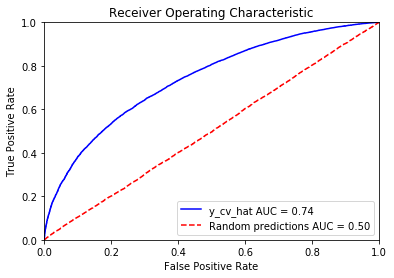

In [30]:
y_alea = np.ones(len(y_cv))
y_alea[:] = np.random.uniform(0, 1, len(y_cv))

alea_fpr, alea_tpr, threshold = roc_curve(y_cv, y_alea)
alea_roc_auc = auc(alea_fpr, alea_tpr)

fpr, tpr, threshold = roc_curve(y_cv, y_cv_hat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'y_cv_hat AUC = %0.2f' % roc_auc)
plt.plot(alea_fpr, alea_tpr, 'r--', label = 'Random predictions AUC = %0.2f' % alea_roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Let's opitmize the recall and the precision ( /!\ precision is not the accuracy )

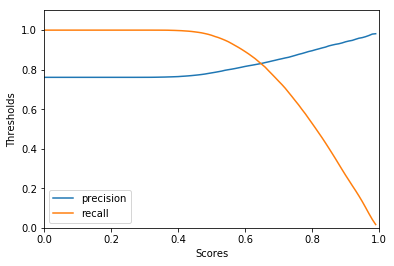

In [31]:
def precision(y_true, y_hat):
    tp = ((y_true == 1) & (y_hat == 1)).sum()
    fp = ((y_true == 0) & (y_hat == 1)).sum()
    return tp / (tp + fp)

def recall(y_true, y_hat):
    tp = ((y_true == 1) & (y_hat == 1)).sum()
    fn = ((y_true == 1) & (y_hat == 0)).sum()
    return tp / (tp + fn)

thresholds = np.arange(0, 1, 0.01)

best_precision = dict()
for th in thresholds:
    best_precision[th] = precision(y_cv, y_cv_hat > th)
    
best_recall = dict()
for th in thresholds:
    best_recall[th] = recall(y_cv, y_cv_hat > th)

plt.plot(thresholds, list(best_precision.values()), label='precision')
plt.plot(thresholds, list(best_recall.values()), label='recall')
plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('Thresholds')
plt.xlabel('Scores')
plt.show()

In [32]:
intersection = []
for x, y in list(zip(best_precision.values(), best_recall.values())):
    intersection.append(abs(x-y))
best_threshold = thresholds[np.argmin(intersection)]
print('The threshold who gives the best recal and precision is : {}'.format(best_threshold))

The threshold who gives the best recal and precision is : 0.65


#### Confusion matrix with best_threshold 

In [33]:
TP = ((y_cv == 1) & ((y_cv_hat > best_threshold) == 1)).sum()
TN = ((y_cv == 0) & ((y_cv_hat > best_threshold) == 0)).sum()
FP = ((y_cv == 0) & ((y_cv_hat > best_threshold) == 1)).sum()
FN = ((y_cv == 1) & ((y_cv_hat > best_threshold) == 0)).sum()

print('                               Predicted condition')
print('                       ----------------------------------')
print('                       |    Positive    |    Negative   |')
print('          -----------------------------------------------')
print('   True   |  Positive  |    {: 10d}  |   {: 10d}  |'.format(TP, FN))
print('Condition |  Negative  |    {: 10d}  |   {: 10d}  |'.format(FP, TN))
print('          -----------------------------------------------')

                               Predicted condition
                       ----------------------------------
                       |    Positive    |    Negative   |
          -----------------------------------------------
   True   |  Positive  |         23991  |         5016  |
Condition |  Negative  |          4851  |         4249  |
          -----------------------------------------------
